In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage
from pathlib import Path

In [3]:
tnia_images_path = Path(r"D:\images")
parent_path=Path(tnia_images_path / r'tnia-python-images/imagesc/2024_04_09_SAM_training')

large_images = tifffile.imread(parent_path / 'training.tif')
large_masks = tifffile.imread(parent_path / 'training_groundtruth.tif')
large_images=large_images[:200,:,:]
large_masks=large_masks[:200,:,:]

In [4]:
large_images.shape

(165, 768, 1024)

In [5]:
#Desired patch size for smaller images and step size.
patch_size = 256
step = 256

In [6]:
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):

            single_patch_img = patches_img[i,j,:,:]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

#Let us do the same for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):

            single_patch_mask = patches_mask[i,j,:,:]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

In [7]:
images.shape, masks.shape

((1980, 256, 256), (1980, 256, 256))

In [8]:
# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)

Image shape: (1642, 256, 256)
Mask shape: (1642, 256, 256)


In [9]:

# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)

Image shape: (1642, 256, 256)
Mask shape: (1642, 256, 256)


In [10]:
from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)
     

c:\Users\bnort\miniconda3\envs\pytorch_and_SAM2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
dataset[10]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>,
 'label': <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>}

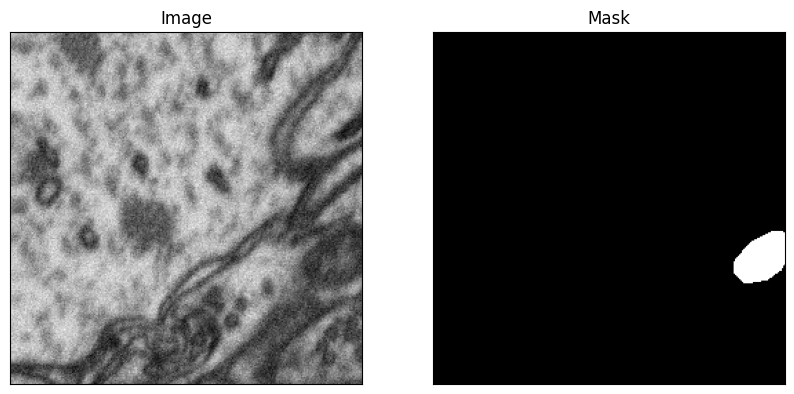

In [13]:

img_num = random.randint(0, filtered_images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [14]:

#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [23]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]

    # add fake channels
    image = np.stack([image, image, image], axis=-1)
    
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [24]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [25]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [26]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

print()
print('original sizes', example['original_sizes'])
print('input box', example['input_boxes'])
print('reshaped sizes',example['reshaped_input_sizes'])

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)

original sizes tensor([256, 256])
input box tensor([[ 328.,    0.,  624., 1024.]], dtype=torch.float64)
reshaped sizes tensor([1024, 1024])


In [27]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, drop_last=False)

In [28]:
model_type = 'vit_b'
checkpoint = 'sam_vit_b_01ec64.pth'
device = 'cuda:0'

In [19]:
from typing import Optional

SAM_WEIGHTS_URL = {
    "default": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth",
    "vit_h": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth",
    "vit_l": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth",
    "vit_b": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth",
}

def get_weights_path(model_type: str) -> Optional[Path]:
    """Returns the path to the weight of a given model architecture."""
    weight_url = SAM_WEIGHTS_URL[model_type]

    cache_dir = Path.home() / ".cache/tnia-sam"
    cache_dir.mkdir(parents=True, exist_ok=True)

    weight_path = cache_dir / weight_url.split("/")[-1]

    # Download the weights if they don't exist
    if not weight_path.exists():
        download_weights(weight_url, weight_path)

    return weight_path

In [20]:
from segment_anything import SamPredictor, sam_model_registry
sam_model = sam_model_registry[model_type](checkpoint=get_weights_path('vit_b'))
sam_model.to(device)
sam_model.train()

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [21]:
sam_model.image_encoder.img_size

1024

In [22]:
import torch

# Set up the optimizer, hyperparameter tuning will improve performance here
lr = 0.0001
wd = 0
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=lr)

loss_fn = torch.nn.MSELoss()
#loss_fn = torch.nn.BCELoss()
#keys = list(bbox_coords.keys())
#sam_model.to(device)
#sam_model.train();

In [23]:
help(threshold)

NameError: name 'threshold' is not defined

In [155]:
from statistics import mean

from tqdm import tqdm
from torch.nn.functional import threshold, normalize
from segment_anything.utils.transforms import ResizeLongestSide
transform = ResizeLongestSide(sam_model.image_encoder.img_size)

num_epochs = 3 
losses = []

for epoch in range(num_epochs):
    print('epoch', epoch)

    epoch_losses = []
    for batch in train_dataloader:

        
        input_image = batch['pixel_values'].to(device)
        original_image_size = batch['original_sizes'][0]
        input_size = batch['reshaped_input_sizes'][0]
        input_size = tuple(input_size)
        #print('original_image_size',original_image_size)
        #print(input_image.shape)
        
        with torch.no_grad():
            image_embedding = sam_model.image_encoder(input_image)   

            prompt_box = batch['input_boxes']
            #print('before transform',prompt_box)
            box = prompt_box #transform.apply_boxes(prompt_box.numpy(), original_image_size.numpy())
            #print('after transform',box)
            box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
            box_torch = box_torch[None, :]
            
            sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
            points=None,
            boxes=box_torch,
            masks=None,
            )
        
        low_res_masks, iou_predictions = sam_model.mask_decoder(
            image_embeddings=image_embedding,
            image_pe=sam_model.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=False,
        )

        #print('low res masks shape',low_res_masks.shape)

        upscaled_masks = sam_model.postprocess_masks(low_res_masks, (1024, 1024), (256,256)).to(device)
        binary_mask = normalize(threshold(upscaled_masks, 0.0, 0))

        #binary_mask = normalize(threshold(low_res_masks, 0.0, 0))
        gt_binary_mask = batch['ground_truth_mask'].unsqueeze(0).to(device).float()
        gt_binary_mask = torch.as_tensor(gt_binary_mask > 0, dtype=torch.float32)
        #print('upscaled masks size', upscaled_masks.size())
        #print('binary mask size',binary_mask.size())
        #print('gt_binary_mask size',gt_binary_mask.size())
        #print('image min max', input_image.max(), input_image.min())
        #print('binary min max',binary_mask.max(), binary_mask.min())
        #print('gt_min_max',gt_binary_mask.max(), gt_binary_mask.min())
        #print()
        #print('gt_binary_mask shape',gt_binary_mask.shape)

        loss = loss_fn(upscaled_masks, gt_binary_mask)
        optimizer.zero_grad()

        #print(loss)

        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())

        '''
        for name, param in sam_model.named_parameters():
            if param.grad is not None:
                print(f"Gradient norm of {name}: {param.grad.norm().item()}")
        '''
    losses.append(epoch_losses)
    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')
        
        
    
        
        

    #ground_truth_mask = batch['ground_truth_mask'].to(device)

        

epoch 0
EPOCH: 0
Mean loss: 0.011405889274453632
epoch 1
EPOCH: 1
Mean loss: 0.009679968842214068
epoch 2
EPOCH: 2
Mean loss: 0.008868212418516715


tensor([[[[   0.,  884.,  400., 1024.]]]], device='cuda:0')


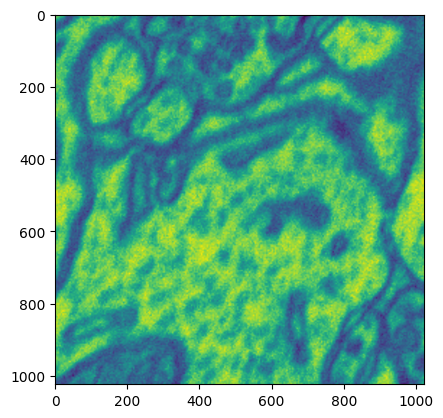

In [156]:
#input_image_ = input_image.squeeze(0).permute(1,2,0).cpu().numpy()
input_image_ = input_image.squeeze(0).cpu().numpy()
input_image_ = input_image_.mean(axis=0)
plt.imshow(input_image_)
input_image_.min(), input_image_.max()
print(box_torch)

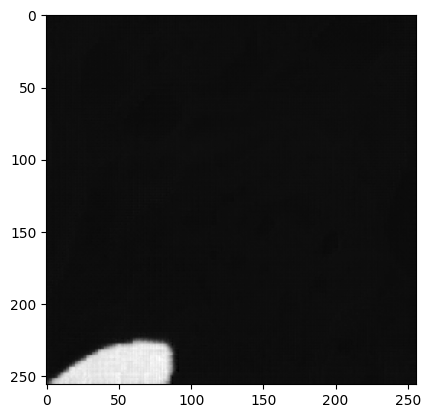

(-0.06325051, 1.1343334)

In [157]:
# convert binary mask to numpy
binary_mask_ = upscaled_masks.detach().cpu().numpy()
gt_binary_mask_ = gt_binary_mask.detach().cpu().numpy()

import matplotlib.pyplot as plt
plt.imshow(binary_mask_.squeeze(), cmap='gray')
plt.show()
binary_mask_.min(), binary_mask_.max()


(0.0, 1.0)

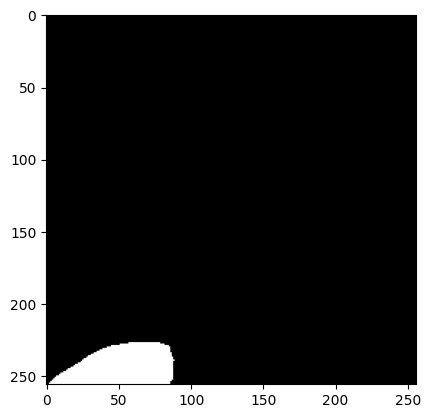

In [158]:
plt.imshow(gt_binary_mask_.squeeze(), cmap='gray')
gt_binary_mask_.min(), gt_binary_mask_.max()

In [134]:
binary_mask_.min(), binary_mask_.max(), gt_binary_mask_.min(), gt_binary_mask_.max()

(0.0, 1.0, 0.0, 1.0)

In [28]:
from segment_anything.automatic_mask_generator import SamAutomaticMaskGenerator
from segment_anything import sam_model_registry, SamPredictor 

In [29]:
from segment_anything import SamPredictor, sam_model_registry
sam_model_vit_b = sam_model_registry[model_type](checkpoint=get_weights_path('vit_b'))
#sam_model_vit_b.to(device)
#sam_model_vit_b.train()

predictor = SamPredictor(sam_model_vit_b)
generator = SamAutomaticMaskGenerator(sam_model_vit_b)

In [30]:
predictor = SamPredictor(sam_model)

In [168]:
generator = SamAutomaticMaskGenerator(sam_model, points_per_batch=32, pred_iou_thresh=0.0001, stability_score_thresh=0.0001)
#sam_model_vit_b.to(device)
#generator = SamAutomaticMaskGenerator(sam_model_vit_b, points_per_batch=32, pred_iou_thresh=0.1, stability_score_thresh=0.1)

In [169]:
test = np.stack([large_images[0], large_images[0], large_images[0]], axis=-1)
result = generator.generate(test)

In [170]:
len(result)

52

In [171]:
from tnia.deeplearning.sam_helper import make_label_image_3d

In [172]:
threed = make_label_image_3d(result)

In [173]:
import napari
viewer = napari.Viewer()
viewer.add_labels(threed)
viewer.add_image(large_images[0])

<Image layer 'Image' at 0x1bf29a20280>